# Transformer code with components split for better understanding and easier manipulation


In [1]:
import pandas as pd
import numpy as np
import sys
import os 
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import torch 

nltk.download('punkt_tab')

sys.path.append(os.path.abspath('..')) 



[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DCCN9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
from src.embedding_models import choose_embedding_model

In [3]:
import random

def set_seed(seed_value=42):
    """Sets the seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        # The two lines below can sometimes slow down training but ensure full reproducibility
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function at the beginning of your script
set_seed()

In [4]:
# Import Pre-Processing
from src.pre_processing import clean_dataset
from src.config import Config
hyperparameters = Config()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DCCN9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DCCN9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DCCN9\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA version: 12.9
Number of GPUs: 1
GPU name: NVIDIA GeForce MX450


In [6]:
train_df = pd.read_json('../Dataset/train.json')
test_df = pd.read_json('../Dataset/test.json')
validation_df = pd.read_json('../Dataset/validation.json')

In [7]:
# Import DataLoader and TensorDataset
from torch.utils.data import TensorDataset, DataLoader

from torch.optim.lr_scheduler import ReduceLROnPlateau

# Pre Processing


Call the pre-processing fucntion inside the src --> pre-processing.clean_dataset()  
Structure :
`clean_dataset(dataset, MIN_WORD_LENGTH=3, MAX_WORD_LENGTH=64, method=None, pos_filter=False, stop_w=False)`

- dataset
- min_word_len --> Set to 3
- max_word_len --> Set to 60
- method (stem,lemmatize) optional
- pos_filter (optional)
- stop_word (optional)


In [8]:
clean_train_dataset = clean_dataset(train_df, stop_w=True, method='', pos_filter=False, max_word_len=64)
clean_test_dataset = clean_dataset(test_df,stop_w=True, method='', pos_filter= False,max_word_len=64 )
clean_validation_dataset = clean_dataset(validation_df,stop_w=True, method=None, pos_filter= False, max_word_len=64 )

# Combine between clean premise and hypothesis
clean_t_dataset = clean_train_dataset['premise'] + clean_train_dataset['hypothesis']

In [9]:
clean_t_dataset.head()

0    [pluto, rotates, axis, every, 6.39, earth, day...
1    [--, -glenn, per, day, earth, rotates, axis, ....
2    [geysers, -, periodic, gush, hot, water, surfa...
3    [facts, liquid, water, droplets, changed, invi...
4    [comparison, earth, rotates, axis, per, day, r...
dtype: object

## Create a unique list of words from both premise and hypothesis


In [10]:
# Create a unique word list from the cleaned dataset
unique_words = set()
for sentence in clean_t_dataset: # Both Premise and Hypothesis 
    for word in sentence:
        unique_words.add(word)

print(f"Count of unique words: {len(unique_words)}")
# No lemma, stem, stop_w, pos_filter = 22134
# With stop_w = 21917
# With stop_w, lemma (took 25 sec) = 18396
# With stop_w, stem (took 10s) = 15403
# Just Stem = 15565
# Just lemma = 18587
# Just Pos Filtering = 21115
# What are we removing in the pos filtering???

Count of unique words: 21940


Sort the word to always have tem ordered


In [11]:
unique_words_list = sorted(list(unique_words))

## Create a dictionary of word-index


Use the enumerate to map a unique index to a unique word


In [12]:
word2id = {w:i for i,w in enumerate(unique_words_list)}
id2word = {i:w for i,w in enumerate(unique_words_list)}

# Build the Embedding Model


Build the embeddings using the gensim, calling the `embedding_model.py`


In [13]:
from gensim.models import FastText

In [14]:
embedding_model = choose_embedding_model(dataset=clean_t_dataset,
                                          vector_size=hyperparameters.emb_size, 
                                          window=hyperparameters.emb_window_size, 
                                          sg=1, 
                                          epochs=hyperparameters.emb_epoch,
                                          batch_words=hyperparameters.emb_batch,
                                          embed_model=hyperparameters.embedding_method)

Loading GloVe Model...
Done. 400000 words loaded!


In [15]:
#embedding_model.wv.most_similar('saturn', topn=10)

# Start of the Transformer Implementation


## Lets first add the necessary special tokens [SEP] [PAD]


In [16]:
SPECIAL_TOKENS = ['[PAD]','[UNK]','[CLS]','[SEP]']
for tok in SPECIAL_TOKENS:
    if tok not in word2id:
        idx = len(word2id)
        word2id[tok] = idx
        id2word[idx] = tok

PAD_ID = word2id['[PAD]'] # Padding token 
UNK_ID = word2id['[UNK]'] # Unknown words token 
CLS_ID = word2id['[CLS]'] # Classification token
SEP_ID = word2id['[SEP]'] # Separation token 

In [17]:
def prepare_transformer_data(df, word2id, max_len):
    input_ids = []
    attention_mask = []
    labels = []

    label_map = {'neutral': 0, 'entails': 1}

    for _, row in df.iterrows():
        premise_toks = row['premise']
        hypothesis_toks = row['hypothesis']
        label = row['label']

        # Add special tokens 
        tokens = [CLS_ID] \
                + [word2id.get(w,UNK_ID) for w in premise_toks] \
                + [SEP_ID] \
                + [word2id.get(w,UNK_ID) for w in hypothesis_toks] 
        # Truncate
        tokens = tokens[:(max_len)] # Double for both premise and hypothesis 

        # Attention mask 
        attn = [1] * len(tokens)

        # Pad
        pad_len = max_len- len(tokens) # To fill the [PAD]
        if pad_len > 0:
            tokens += [PAD_ID] * pad_len
            attn += [0] * pad_len # FLag positions as padding 

        input_ids.append(tokens)
        attention_mask.append(attn)
        labels.append(label_map[label])

    return (torch.LongTensor(input_ids),
            torch.LongTensor(attention_mask),
            torch.LongTensor(labels))
    

In [18]:
# Build train/test
x_train, train_masks, y_train = prepare_transformer_data(clean_train_dataset, word2id, hyperparameters.max_trans_len)
x_test,  test_masks,  y_test  = prepare_transformer_data(clean_test_dataset,  word2id, hyperparameters.max_trans_len)
x_valid,  valid_masks,  y_valid  = prepare_transformer_data(clean_validation_dataset,  word2id, hyperparameters.max_trans_len)

print("Shape of x_train:", x_train.shape)
print("Shape of train_masks:", train_masks.shape)
print("Shape of y_train:", y_train.shape)

# Sanity Check 
i = 0
print("\n--- Example ---")
print("First example real length (mask sum):", int(train_masks[i].sum()))
print("First example PAD count:", int((train_masks[i]==0).sum()))

Shape of x_train: torch.Size([22935, 130])
Shape of train_masks: torch.Size([22935, 130])
Shape of y_train: torch.Size([22935])

--- Example ---
First example real length (mask sum): 16
First example PAD count: 114


In [19]:
train_masks[0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
sentence = []
for x in x_train[0]:
    sentence.append(id2word[int(x)])

print(sentence)

['[CLS]', 'pluto', 'rotates', 'axis', 'every', '6.39', 'earth', 'days', '[SEP]', 'earth', 'rotates', 'axis', 'times', 'one', 'day', '.', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',

## Positional Encoding


In [21]:
import math
import torch
import torch.nn as nn


class PositionalEncoding(nn.Module):
    
    def __init__(self,d_model,max_len = 512, dropout = 0.1):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0,max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0) / d_model))
        pe[:,0::2] = torch.sin(position * div_term) # For even dims
        pe[:,1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        x = x + self.pe[:, :x.size(1), :] 
        return self.dropout(x)
        

In [22]:

def build_embedding_matrix(word2id, pretrained_vectors, embedding_size):
    vocab_size = len(word2id)
    embedding_matrix = np.zeros((vocab_size, embedding_size), dtype=np.float32)

    # Fill the matrix with pre-trained vectors
    for word, idx in word2id.items():
        if word == '[PAD]':
            continue
        try:
            vec = pretrained_vectors[word]
            if vec.shape[0] == embedding_size:
                embedding_matrix[idx] = vec.astype(np.float32)
            else:
                # fallback if dims don’t match
                embedding_matrix[idx] = np.random.normal(0.0, 0.02, size=(embedding_size,)).astype(np.float32)
        except KeyError:
            # special tokens or OOV start them with random values 
            embedding_matrix[idx] = np.random.normal(0.0, 0.02, size=(embedding_size,)).astype(np.float32)

    print("Embedding matrix created with shape:", embedding_matrix.shape)

    return embedding_matrix

In [23]:
class TransformerClassifier(nn.Module):
    def __init__(self, embedding_matrix, num_classes, n_heads, n_layers, dropout):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.d_model = embed_dim

        # Embedding Layer
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False, padding_idx=PAD_ID)
        # TO (learning from scratch):
        #self.embedding = nn.Embedding(vocab_size, self.d_model, padding_idx=PAD_ID)


        self.seg_embed = nn.Embedding(2, embed_dim)
        # Positional Encoding
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=hyperparameters.max_trans_len, dropout=dropout)

        # Transformer Encoder Layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=n_heads,
            dropout=dropout,
            dim_feedforward=(embed_dim*4), # Use 4 time the size of embedding 
            batch_first=True # Makes working with batch dimension easier
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer,num_layers=n_layers)

        # classifier head
        self.pool_norm = nn.LayerNorm(embed_dim)
        #self.classifier = nn.Linear(embed_dim, num_classes)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim,embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim,num_classes)
        )

        ## Final Classification Head
        #self.classifier = nn.Linear(embed_dim,num_classes)

    def forward(self, src, src_mask):
        padding_mask = (src_mask == 0)

        # Apply embedding and positional encoding
        embedded = self.embedding(src) * math.sqrt(self.d_model)
        pos_encoded = self.pos_encoder(embedded)

        # Pass trough the transformer encoder
        encoded = self.transformer_encoder(pos_encoded,src_key_padding_mask = padding_mask)

        # Use the output of the [CLS] token (first token) for classification
        cls_output = encoded[:,0,:]


        # Get final logits from the classifier
        logits = self.classifier(cls_output)
        return logits
    

    # Add this method INSIDE your TransformerClassifier class in daniel_transformer2.ipynb

    def get_attention_weights(self, src, src_mask):
        """
        Gets the attention weights from the first encoder layer.
        """
        # 1. Get embeddings and positional encoding
        padding_mask = (src_mask == 0)
        embedded = self.embedding(src) * math.sqrt(self.d_model)
        pos_encoded = self.pos_encoder(embedded)

        # 2. Access the FIRST encoder layer directly from the nn.ModuleList
        first_encoder_layer = self.transformer_encoder.layers[0]

        # 3. Call its self-attention module with need_weights=True
        # This is the key step that returns the weights.
        # We set average_attn_weights=False to see what each head is doing individually.
        _, attn_weights = first_encoder_layer.self_attn(
            pos_encoded, pos_encoded, pos_encoded,
            key_padding_mask=padding_mask,
            need_weights=True,
            average_attn_weights=False
        )

        return attn_weights.cpu().detach()

In [24]:
def plot_attention_head(attention_weights, tokens, head_index):
    """Plots a readable heatmap for a single attention head, ignoring padding."""
    
    # 1. Find the actual length of the sentence by finding the first [PAD] token
    try:
        real_len = tokens.index('[PAD]')
    except ValueError:
        real_len = len(tokens)

    # 2. Slice the tokens and weights to remove padding
    tokens_no_padding = tokens[:real_len]
    head_weights = attention_weights[0, head_index][:real_len, :real_len]
    
    # 3. Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        head_weights, 
        xticklabels=tokens_no_padding, 
        yticklabels=tokens_no_padding, 
        cmap='viridis', 
        ax=ax
    )
    
    ax.set_title(f'Attention Head #{head_index} (Padding Removed)')
    plt.show()


In [25]:
# Modify Hyperparameters
import importlib
import src.config
from src.config import Config
importlib.reload(src.config)
from src.config import Config
hyperparameters = Config()

In [26]:
print(hyperparameters.batch_size)

64


In [27]:
# Prepare the transformer data 

# First, build the embedding matrix using the function you wrote
if hyperparameters.embedding_method == "FastText":
    pretrained_vectors = embedding_model.wv
elif hyperparameters.embedding_method == "GloVe":
    pretrained_vectors = embedding_model

embedding_matrix = build_embedding_matrix(word2id, pretrained_vectors, hyperparameters.emb_size)
# Ex. word_id = 0, Word = "Saturn" vector [-0.26502675 -0.00755045  0.09107253 -0.13402076  0.22515745, ...]

# Now, instantiate the model
transformer_model = TransformerClassifier(
    embedding_matrix=embedding_matrix,
    num_classes=hyperparameters.num_classes,
    n_heads=hyperparameters.n_heads,
    n_layers=hyperparameters.n_layers,
    dropout=hyperparameters.dropout
)

# Datasets
train_ds = TensorDataset(x_train, train_masks,y_train)
test_ds = TensorDataset(x_test, test_masks,y_test)
valid_ds = TensorDataset(x_valid, valid_masks,y_valid)

# Dataloaders (shuffle for train)
train_loader = DataLoader(train_ds, batch_size=hyperparameters.batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=hyperparameters.batch_size, shuffle=False, num_workers=2)
valid_loader = DataLoader(valid_ds, batch_size=hyperparameters.batch_size, shuffle=False, num_workers=2)

#

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer_model.to(device)

counts = torch.bincount(y_train)
freq   = counts.float() / counts.sum()
weights = (1.0 / (freq + 1e-8))
weights = (weights / weights.mean()).to(device)

criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=hyperparameters.label_smoothing)
optimizer = torch.optim.AdamW(transformer_model.parameters(), lr = hyperparameters.lr, weight_decay=hyperparameters.wd)

# Initialize the scheduler to reduce the lr on the process
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.2,
    patience=1,
)


Embedding matrix created with shape: (21944, 200)


In [28]:
weights

tensor([0.7383, 1.2617], device='cuda:0')

In [29]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total = 0

    for xb, mb, yb in loader: # x_train, train_mask, y_train
        xb,mb,yb = xb.to(device), mb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb, mb)
        loss = criterion(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)# Gradient clipping, prevents gradients to become to large 
        optimizer.step()

        total_loss += loss.item() * yb.size(0)
        preds = logits.argmax(1)
        total_correct += (preds == yb).sum().item()
        total += yb.size(0)
    return total_loss/total, total_correct/total

@torch.no_grad() #For everything inside this function, don’t track gradients.
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total = 0
    for input_ids, attention_mask, labels in loader:
        input_ids      = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels         = labels.to(device)

        logits = model(input_ids, attention_mask)
        loss   = criterion(logits, labels)

        total_loss   += loss.item() * labels.size(0)
        preds         = logits.argmax(1)
        total_correct+= (preds == labels).sum().item()
        total        += labels.size(0)
    return total_loss/total, total_correct/total


In [30]:
def train_model(transformer_model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transformer_model.to(device)
    print(device)
    # Early Stopping params
    patience = 5
    patience_counter = 0
    best_val_loss = float('inf') #Starts with a high number
    best_model_path = "best_transformer_model.pth"


    # Main training loop
    for epoch in range(hyperparameters.train_num_epoch):
        train_loss, train_acc = train_epoch(transformer_model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(transformer_model, valid_loader, criterion, device)
        print(f"Epoch {epoch+1}/{hyperparameters.train_num_epoch} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        #Update the scheduler
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model weights
            torch.save(transformer_model.state_dict(), best_model_path)
            print(f"  -> Validation loss improved to {best_val_loss:.4f}. Saving model.")
        else:
            patience_counter += 1
            print(f"  -> Validation loss did not improve. Patience {patience_counter}/{patience}.")

        if patience_counter >= patience:
            print("Early stopping")
            break

    print("Training complete.")

    # Use the best model considering the validation loss
    print(f"Loading best model from {best_model_path} with val_loss: {best_val_loss:.4f}")
    transformer_model.load_state_dict(torch.load(best_model_path))

    test_loss, test_acc = evaluate(transformer_model, test_loader, criterion, device)
    print(f"FINAL TEST - Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")


In [31]:
train_model(transformer_model)

cuda


c:\Users\DCCN9\OneDrive - UWA\Data Science\Semester July-November 2025\CITS4012 - Natural Language Processing\Team Assignment 2 NLP\.venv\Lib\site-packages\torch\nn\modules\transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch 1/7 - Train Loss: 0.6801, Train Acc: 0.5582 - Val Loss: 0.6266, Val Acc: 0.6559
  -> Validation loss improved to 0.6266. Saving model.
Epoch 2/7 - Train Loss: 0.6522, Train Acc: 0.6142 - Val Loss: 0.5978, Val Acc: 0.6482
  -> Validation loss improved to 0.5978. Saving model.
Epoch 3/7 - Train Loss: 0.6228, Train Acc: 0.6555 - Val Loss: 0.5921, Val Acc: 0.6490
  -> Validation loss improved to 0.5921. Saving model.
Epoch 4/7 - Train Loss: 0.6029, Train Acc: 0.6764 - Val Loss: 0.5809, Val Acc: 0.6751
  -> Validation loss improved to 0.5809. Saving model.
Epoch 5/7 - Train Loss: 0.5756, Train Acc: 0.7037 - Val Loss: 0.5792, Val Acc: 0.6690
  -> Validation loss improved to 0.5792. Saving model.
Epoch 6/7 - Train Loss: 0.5613, Train Acc: 0.7168 - Val Loss: 0.5837, Val Acc: 0.6866
  -> Validation loss did not improve. Patience 1/5.
Epoch 7/7 - Train Loss: 0.5439, Train Acc: 0.7314 - Val Loss: 0.5811, Val Acc: 0.6874
  -> Validation loss did not improve. Patience 2/5.
Training complete.


In [32]:
clean_test_dataset['label'].value_counts()

label
neutral    1279
entails     842
Name: count, dtype: int64

In [33]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

transformer_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids      = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels         = labels.to(device)

        logits = transformer_model(input_ids, attention_mask)
        preds = logits.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

print("Accuracy:", round(accuracy_score(all_labels, all_preds), 2))
print(f"F1 Score: {f1_score(all_labels, all_preds):.2f}")
print("Precision:", round(precision_score(all_labels, all_preds), 2))
print("Recall:", round(recall_score(all_labels, all_preds), 2))
print("-" * 40)
print(classification_report(all_labels, all_preds, target_names=["neutral", "entails"]))

# Hyperparameters Transformer
print('-' * 40)
print('Hyperparameters Transformer')
print('Batch Size', hyperparameters.batch_size)
print('Num of Epochs', hyperparameters.train_num_epoch)
print('Learning Rate', hyperparameters.lr)
print('Num Classes', hyperparameters.num_classes)
print('Number of Heads', hyperparameters.n_heads)
print('Numer of Layers', hyperparameters.n_layers)
print('Embedding Dimensions', hyperparameters.emb_size)
print('Dropout', hyperparameters.dropout)
print('Weight Decay', hyperparameters.wd)
#Print embedding HyperParameters
print('-' * 40)
print('Embedding Hyperparameters')
print('Embedding Batch', hyperparameters.emb_batch)
print('Max pre-processing len:', hyperparameters.max_pre_pros_len)
print('Embedding size:', hyperparameters.emb_size)
print('Embedding lr:', hyperparameters.emb_lr)
print('Embedding Epoch:', hyperparameters.emb_epoch)
print('Embedding Window Size:', hyperparameters.emb_window_size)



Accuracy: 0.65
F1 Score: 0.63
Precision: 0.54
Recall: 0.77
----------------------------------------
              precision    recall  f1-score   support

     neutral       0.79      0.57      0.66      1279
     entails       0.54      0.77      0.63       842

    accuracy                           0.65      2121
   macro avg       0.66      0.67      0.65      2121
weighted avg       0.69      0.65      0.65      2121

----------------------------------------
Hyperparameters Transformer
Batch Size 64
Num of Epochs 7
Learning Rate 5e-05
Num Classes 2
Number of Heads 2
Numer of Layers 2
Embedding Dimensions 200
Dropout 0.2
Weight Decay 0.003
----------------------------------------
Embedding Hyperparameters
Embedding Batch 512
Max pre-processing len: 128
Embedding size: 200
Embedding lr: 0.0005
Embedding Epoch: 3
Embedding Window Size: 5


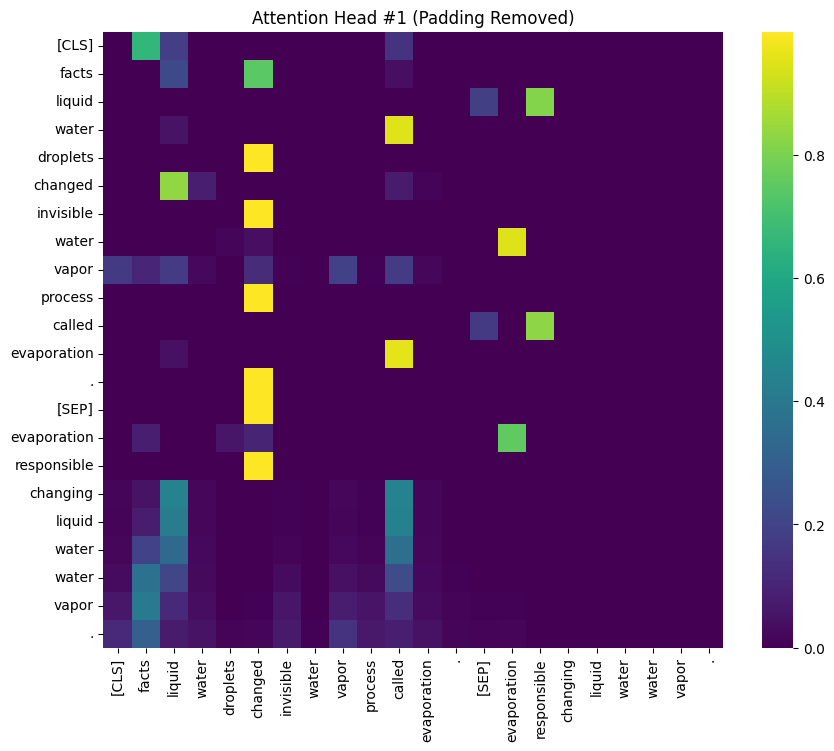

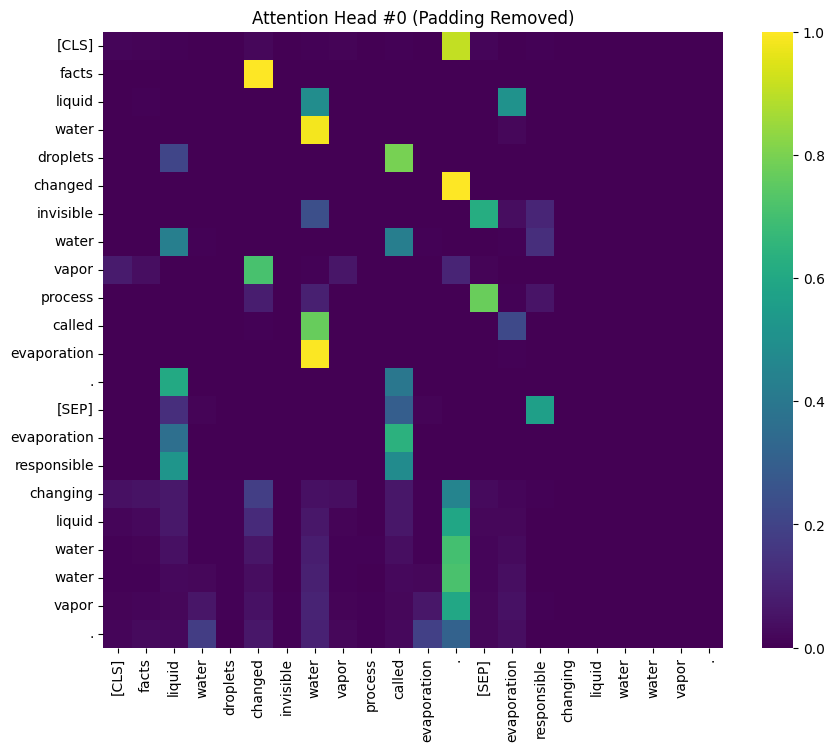

In [34]:
# Get the attention 
sample_token_ids = x_train[0].unsqueeze(0)
sample_mask = train_masks[0].unsqueeze(0)

# 2. Convert the token IDs back to words for the plot labels
# This is the key step you were asking about
plot_tokens = [id2word[int(token_id)] for token_id in x_train[3]]

# Get the attention weights from the model
attention_weights = transformer_model.get_attention_weights(
    sample_token_ids.to(device),
    sample_mask.to(device)
)

# Plot the attention for the first head (head 0)
plot_attention_head(attention_weights, plot_tokens, head_index=1)
plot_attention_head(attention_weights, plot_tokens, head_index=0)

# You can plot other heads by changing the head_index
# For example, if you have n_heads=2:
# plot_attention_head(attention_weights, plot_tokens, head_index=1)